**Module**: read_aod_and_calculate_pm25.ipynb

**Disclaimer**: The code is for demonstration purposes only. Users are responsible to check for accuracy and revise to fit their objective.

**Organization**: NASA ARSET

**Author**: Justin Roberts-Pierel & Pawan Gupta, 2015

**Modified for DB VIIRS**: Aavash Thapa, May 10 2019

**Modified for Cartopy by**: Amanda Markert, University of Alabama in Huntsville, June 2019

Modified: Pawan Gupta, September 28 2021 to work with VIIRS DT data

**Purpose**: To extract AOD data from a VIIRS NC file (or series of files), 
calculate PM 2.5 from the data, and create a map of the results. (***NOTE: the default slope used in this code is meant for demonstrative purposes only and is not meant to be used for quantitative analyses***)


In [1]:
#Mount drive to save files there
#clone the repository to access files from there
#pull the latest
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
! git clone https://github.com/pawanpgupta/DTAerosols.git
! git -C DTAerosols/ pull

Mounted at /content/drive
Cloning into 'DTAerosols'...
remote: Enumerating objects: 18, done.
remote: Counting objects: 100% (18/18), done.
remote: Compressing objects: 100% (16/16), done.
remote: Total 18 (delta 4), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (18/18), done.
Already up to date.


In [2]:
!pip install "imgaug==0.2.5"
!pip install netCDF4

# !apt-get -qq install python-cartopy python3-cartopy;
!pip uninstall -y shapely;    # cartopy and shapely aren't friends (early 2020)

# shapely needs to be built from source to link to geos. If it is already
# installed, uninstall it by: pip3 uninstall shapely
!pip3 install --upgrade pyshp
!pip install shapely --no-binary shapely;
!pip install cartopy --upgrade

     |████████████████████████████████| 562 kB 7.4 MB/s 
  Created wheel for imgaug: filename=imgaug-0.2.5-py3-none-any.whl size=561438 sha256=7f3030696ebbb1531b766bb911a69098622f6eb1b096a619c6de1ebbb582b05a
  Stored in directory: /root/.cache/pip/wheels/60/dd/38/d1dc2cad2b6a66dc0249261004990bccb0f27985c74ba26e49
Successfully built imgaug
  Attempting uninstall: imgaug
    Found existing installation: imgaug 0.2.9
    Uninstalling imgaug-0.2.9:
      Successfully uninstalled imgaug-0.2.9
Found existing installation: Shapely 1.7.1
Uninstalling Shapely-1.7.1:
  Successfully uninstalled Shapely-1.7.1
     |████████████████████████████████| 219 kB 8.7 MB/s 
  Created wheel for pyshp: filename=pyshp-2.1.3-py3-none-any.whl size=37325 sha256=68cc8e63cf9b9f12c9e68942cbce2f6aafc2dbca48212eff0bf09fc00aa99637
  Stored in directory: /root/.cache/pip/wheels/43/f8/87/53c8cd41545ba20e536ea29a8fcb5431b5f477ca50d5dffbbe
Successfully built pyshp
     |████████████████████████████████| 383 kB 6.5 MB/s 
S

In [3]:
import numpy as np
import pandas as pd
import sys
from netCDF4 import Dataset
import matplotlib.pyplot as plt
#from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.axes import Axes
from textwrap import wrap
from cartopy.mpl.geoaxes import GeoAxes
import cartopy.crs as ccrs
GeoAxes._pcolormesh_patched = Axes.pcolormesh

In [4]:
# Change the path to the appropriate cartopy_feature_download.py on google drive
!python "drive/MyDrive/Colab Notebooks/cartopy_feature_download.py" physical

/usr/local/lib/python3.7/dist-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/110m_physical/ne_110m_coastline.zip
  warnings.warn('Downloading: {}'.format(url), DownloadWarning)
Feature physical, coastline, 110m length: 134
/usr/local/lib/python3.7/dist-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/50m_physical/ne_50m_coastline.zip
  warnings.warn('Downloading: {}'.format(url), DownloadWarning)
Feature physical, coastline, 50m length: 1428
/usr/local/lib/python3.7/dist-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/10m_physical/ne_10m_coastline.zip
  warnings.warn('Downloading: {}'.format(url), DownloadWarning)
Feature physical, coastline, 10m length: 4133
/usr/local/lib/python3.7/dist-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/110m_physical/ne_110m_land

Mounted at /content/drive

The valid range of values is:  -50  to  5000 
The average is:  0.186 
The standard deviation is:  0.321
The range of latitude in this file is:  19.32293128967285  to  44.45458984375 degrees 
The range of longitude in this file is:  -136.28750610351562  to  -97.96835327148438  degrees


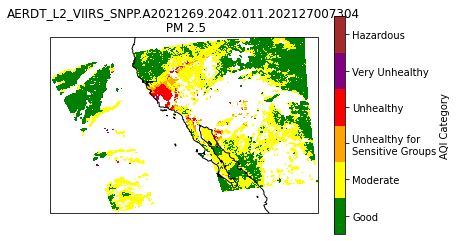

In [ ]:
#!/usr/bin/python
# =============================================================================
# Inputs
#This uses the file "fileList.txt", containing the list of files, in order to read the file

try:
    from google.colab import drive
    drive.mount('/content/drive', force_remount=True)
    fileList = open('DTAerosols/fileList.txt', 'r')
except:
    print('Did not find a text file containing file names (perhaps name does not match)')
    sys.exit()

#loops through all files listed in the text file
for FILE_NAME in fileList:
    FILE_NAME=FILE_NAME.strip()
    # FILE_NAME = 'AERDB_L2_VIIRS_SNPP.A2020056.1954.001.2020057113600.nc'
    #change 'raw_input' to 'input' if an error is shown about the input
    user_input=input('\nWould you like to process\n' + FILE_NAME + '\n\n(Y/N)')
    if(user_input == 'N' or user_input == 'n'):
        print('Skipping...')
        continue
    else:
        ds = Dataset('DTAerosols/'+ FILE_NAME, 'r')
# read the data
        # print(geods.variables)
        #grp='PRODUCT'   
        grp='/geolocation_data/'
        geods = ds[grp] 
        lat= geods.variables['latitude'][:][:]
        lon= geods.variables['longitude'][:][:]
        if 'AERDT' in FILE_NAME:
           #The user has a choice of 5 sds variable and has to input a number to choose.
            #The loop keeps repeating until the user inputs a value between 1-5 inclusive.
            while  True:
              choice = input("""Pick the number with the corresponding sds variable of your choice: 
              1) Image_Optical_Depth_Land_And_Ocean
              2) Optical_Depth_Land_And_Ocean """)
        
              if choice in ['1', '2']:
                break
              else:
                print("Please input a valid response!")


            if choice == '1':
              sds_name='Image_Optical_Depth_Land_And_Ocean'
            elif choice =='2':
              sds_name='Optical_Depth_Land_And_Ocean'
        data= ds['/geophysical_data/'].variables[sds_name]      
        map_label = sds_name
        map_label = map_label.replace('_', ' ')
        map_label = '\n'.join(wrap(map_label, 40))
        #get necessary attributes 
        fv=data._FillValue
        
        #get lat and lon information 
        min_lat=np.min(lat)
        max_lat=np.max(lat)
        min_lon=np.min(lon)
        max_lon=np.max(lon)

        #get valid range for AOD SDS
        range=data.getncattr("valid_range")
        min_range=min(range)
        max_range=max(range)
        
        #get data within valid range
        dataArray=np.array(data[:][:])
        dataArray = np.multiply(dataArray, 1.0)
        fv = fv*1.0
        dataArray[dataArray==fv]=np.nan
        data=dataArray
        valid_data = data.ravel()
        valid_data=[x for x in valid_data if x>=min_range]
        valid_data=[x for x in valid_data if x<=max_range]
        valid_data=np.asarray(valid_data)
        #find the average
        average=sum(valid_data)/len(valid_data)
        #find the standard deviation
        stdev=np.std(valid_data)
        #print information
        print('\nThe valid range of values is: ',round(min_range,3), ' to ',round(max_range,3),'\nThe average is: ',round(average,3),'\nThe standard deviation is: ',round(stdev,3))
        print('The range of latitude in this file is: ',min_lat,' to ',max_lat, 'degrees \nThe range of longitude in this file is: ',min_lon, ' to ',max_lon,' degrees')
        

        #asks user if they want to set PM2.5 calculation parameters
        user_input=input('\nWould you like to enter a slope and intercept for PM 2.5 calculation? (Y/N)')
        if user_input == 'Y' or user_input == 'y': 
            slope=input('Please enter a slope: ')
            intercept=input('Please enter an intercept: ')
        else:
            #if not, choose the following:
            slope=40.0
            intercept=8.0
        valid_data=data
        pm25=float(slope)*valid_data+float(intercept)
        
        
        
        #Asks user if they would like to see a map
        is_map=input('\nWould you like to create a map of this data? Please enter Y or N \n')
        #if user would like a map, view it
        if is_map == 'Y' or is_map == 'y':
            
            #turn fillvalues to NaN
            data=pm25.astype(float)
            data[np.logical_and(data>=0,data <= 12)]=0
            data[np.logical_and(data>12,data <= 35.4)]=1
            data[np.logical_and(data>35.4,data <= 55.4)]=2
            data[np.logical_and(data>55.4,data <= 150.4)]=3
            data[np.logical_and(data>150.4,data <= 250.4)]=4
            data[data>250.4]=5
            data[data < 0] = np.nan
            
            #create the map
            data = np.ma.masked_array(data, np.isnan(data))
            
            extent = (min_lon, max_lon, min_lat, max_lat)
            m = plt.axes(projection=ccrs.PlateCarree())
            m.set_extent(extent)
            
            my_cmap=LinearSegmentedColormap.from_list('mycmap', ['green','yellow','orange','red','purple','brown'],6)
            plt.pcolormesh(lon, lat, data,cmap=my_cmap, transform=ccrs.PlateCarree())
            plt.clim(0,6)
             
            #create colorbar
            cb = plt.colorbar()
            cb.set_label('AQI Category')
            cb.set_ticks([.5, 1.5,2.5,3.5,4.5,5.5])  # force there to be only 7 ticks
            cb.set_ticklabels(['Good', 'Moderate', 'Unhealthy for \nSensitive Groups','Unhealthy','Very Unhealthy','Hazardous'])  # put text labels on them
            
            m.coastlines()
            """
            grd = m.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=2, color='gray', alpha=0.5, linestyle='--')
            grd.xlabels_top = None
            grd.ylabels_right = None
            grd.xformatter = LONGITUDE_FORMATTER
            grd.yformatter = LATITUDE_FORMATTER
            """
            plt.autoscale()
            
            #title the plot
            plotTitle=FILE_NAME[:-4]
            plt.title('{0}\n {1}'.format(plotTitle, 'PM 2.5'))
            fig = plt.gcf()
            # Show the plot window.
            plt.show()
            
            #once you close the map it asks if you'd like to save it
            is_save=str(input('\nWould you like to save this map? Please enter Y or N \n'))
            if is_save == 'Y' or is_save == 'y':
                #saves as a png if the user would like5
                pngfile = '{0}.png'.format(plotTitle, 'PM 2.5')
                fig.savefig('/content/drive/My Drive/Colab Notebooks/' + pngfile)
            
            
